## Language Models

Text is an important example of sequence data. In fact, we will use natural language models as the basis for many of the
examples in this chapter. Given that, it’s worth while discussing some things in a bit more detail. In the following we will
view words (or sequences of characters) as a time series of discrete observations. Assuming the words in a text of length
T are in turn w<sub>1</sub>;w<sub>2</sub>; . . . ;w<sub>T</sub> , then, in the discrete time series, wt(1 < t < T) can be considered as the output or label
of time step t. Given such a sequence,<i>the goal of a language model is to estimate the probability</i>

<h3 style="text-align: center;font-weight: bold:font-size:30px">p(w<sub>1</sub>;w<sub>2</sub>; . . . ;w<sub>T</sub> )</h3>

Language models are incredibly useful. For instance, an ideal language model would be able to generate natural text just
on its own, simply by drawing one word at a time wt ~ p(w<sub>t</sub>|w<sub>t-1</sub>; . . .w<sub>1</sub> ) Quite unlike the monkey using a typewriter,
all text emerging from such a model would pass as natural language, e.g. English text. Furthermore, it would be sufficient
for generating a meaningful dialog, simply by conditioning the text on previous dialog fragments. Clearly we are still
very far from designing such a system, since it would need to understand the text rather than just generate grammatically
sensible content.

Nonetheless language models are of great service even in their limited form. For instance, the phrases <i>‘to recognize
speech’</i> and <i>‘to wreck a nice beach’</i> sound very similar. This can cause ambiguity in speech recognition, ambiguity that
is easily resolved through a language model which rejects the second translation as outlandish. Likewise, in a document
summarization algorithm it’s worth while knowing that<i> ‘dog bites man’</i> is much more frequent than <i>‘man bites dog’</i>, or that
<i>‘let’s eat grandma’</i> is a rather disturbing statement, whereas<i> ‘let’s eat, grandma’ </i>is much more benign.

## Estimating a language model

The obvious question is how we should model a document, or even a sequence of words. We can take recourse to the
analysis we applied to sequence models in the previous section. Let’s start by applying basic probability rules:

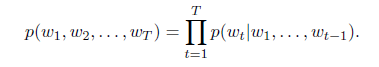

In [4]:
from IPython.display import Image
Image(filename="../img/prob-seq-text.png")

For example, the probability of a text sequence containing four tokens consisting of words and punctuation would be given
as:

<center>p(Statistics; is; fun; .) = p(Statistics)p(is|Statistics)p(fun|Statistics; is)p(.|Statistics; is; fun)</center>

In order to compute the language model, we need to calculate the probability of words and the conditional probability
of a word given the previous few words, i.e. language model parameters. Here, we assume that the training data set is a
large text corpus, such as all Wikipedia entries, Project Gutenberg, or all text posted online on the web. The probability
of words can be calculated from the relative word frequency of a given word in the training data set.
For example, p(Statistics) can be calculated as the probability of any sentence starting with the word ‘statistics’. A slightly
less accurate approach would be to count all occurrences of the word ‘statistics’ and divide it by the total number of words
in the corpus. This works fairly well, particularly for frequent words.

<center>p(is|Statistics) =
    n(Statistics is)/
n(Statistics)</center>


Here n(w) and n(w;w′) are the number of occurrences of singletons and pairs of words respectively. Unfortunately,
estimating the probability of a word pair is somewhat more difficult, since the occurrences of <I>‘Statistics is’</I> are a lot less
frequent. In particular, for some unusual word combinations it may be tricky to find enough occurrences to get accurate
estimates. Things take a turn for the worse for 3 word combinations and beyond. There will be many plausible 3-word
combinations that we likely won’t see in our dataset. Unless we provide some solution to give such word combinations
nonzero weight we will not be able to use these as a language model. If the dataset is small or if the words are very rare,
we might not find even a single one of them.

A common strategy is to perform some form of Laplace smoothing. We already encountered this in our discussion of
naive bayes where the solution was to add a small constant to all counts. This helps with singletons, e.g. via

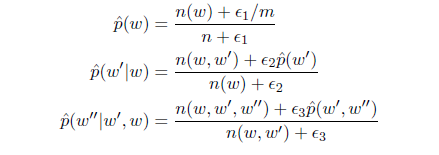

In [3]:
from IPython.display import Image
Image(filename="../img/Lapalace_smoothning.png")

Here the coefficients ϵ<sub>i</sub >> 0 determine how much we use the estimate for a shorter sequence as a fill-in for longer ones.
Moreover, m is the total number of words we encounter. The above is a rather primitive variant of what is Kneser-Ney
smoothing and Bayesian Nonparametrics can accomplish. See e.g. the Sequence Memoizer of Wood et al., 2012 for more
details of how to accomplish this. Unfortunately models like this get unwieldy rather quickly: first off, we need to store all
counts and secondly, this entirely ignores the meaning of the words. For instance, ‘cat’ and ‘feline’ should occur in related
contexts. Deep learning based language models are well suited to take this into account. This, it is quite difficult to adjust
such models to additional context. Lastly, long word sequences are almost certain to be novel, hence a model that simply
counts the frequency of previously seen word sequences is bound to perform poorly there.

## Markov Models and n-grams

Before we discuss solutions involving deep learning we need some more terminology and concepts. Recall our discussion
of Markov Models in the previous section. Let’s apply this to language modeling. A distribution over sequences
satisfies the Markov property of first order if p(w<sub>t+1</sub>|w<sub>t</sub>; . . .w<sub>1</sub>) = p(w<sub>t+1</sub>|w<sub>t</sub>). Higher orders correspond to longer
dependencies. This leads to a number of approximations that we could apply to model a sequence:

<center>p(w1;w2;w3;w4) = p(w1)p(w2)p(w3)p(w4)</center>
<center>p(w1;w2;w3;w4) = p(w1)p(w2|w1)p(w3|w2)p(w4|w3)</center>
<center>p(w1;w2;w3;w4) = p(w1)p(w2|w1)p(w3|w1;w2)p(w4|w2;w3)</center>

Since they involve one, two or three terms, these are typically referred to as unigram, bigram and trigram models. In the
following we will learn how to design better models.

## Natural Language Statistics

Let’s see how this works on real data. To get started we load text from H.G. Wells’ Time Machine. This is a fairly small
corpus of just over 30,000 words but for the purpose of what we want to illustrate this is just fine. More realistic document
collections contain many billions of words. To begin, we split the document up into words and ignore punctuation and
capitalization. While this discards some relevant information, it is useful for computing count statistics in general. Let’s
see what the first few lines look like.

In [2]:
import sys
sys.path.insert(0, '..')

import collections
import re

In [3]:
with open('../data/timemachine.txt', 'r') as f:
    lines = f.readlines()
    raw_dataset = [re.sub('[^A-Za-z]+', ' ', st).lower().split()
                   for st in lines]

for st in raw_dataset[8:12]:
    print('tokens:', len(st), st)

tokens: 13 ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
tokens: 12 ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
tokens: 11 ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
tokens: 10 ['fire', 'burned', 'brightly', 'and', 'the', 'soft', 'radiance', 'of', 'the', 'incandescent']


Now we need to insert this into a word counter. This is where the <I>collections</I> datastructure comes in handy. It takes
care of all the accounting for us.

In [4]:
counter = collections.Counter([t for s in raw_dataset for t in s])
print("frequency of 'traveller':", counter['traveller'])

print(counter.most_common(10))

frequency of 'traveller': 183
[('the', 6782), ('i', 3801), ('and', 3735), ('of', 3465), ('a', 2448), ('to', 2085), ('was', 1656), ('in', 1623), ('that', 1329), ('my', 1320)]


As we can see, the most popular words are actually quite boring to look at. In traditional NLP they’re often referred to
as stopwords and thus filtered out. That said, they still carry meaning and we will use them nonetheless. However, one
thing that is quite clear is that the word frequency decays rather rapidly. The 10th word is less than 1/
5 as common as the
most popular one. To get a better idea we plot the graph of word frequencies.

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

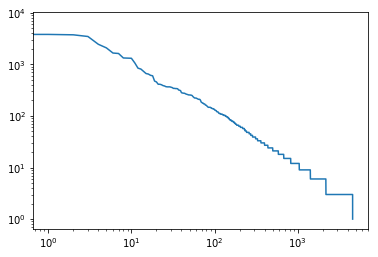

In [6]:
wordcounts = [count for i,count in counter.most_common()]
plt.loglog(wordcounts);

We’re on to something quite fundamental here - the word frequencies decay rapidly in a well defined way. After dealing
with the first four words as exceptions (‘the’, ‘i’, ‘and’, ‘of’), all remaining words follow a straight line on a log-log plot.
This means that words satisfy Zipf’s law which states that the item frequency is given by

n(x) ~ (x + c)
<sup>-a</sup> and hence log n(x) = -a log(x + c) + const:

This should already give us pause if we want to model words by count statistics and smoothing. After all, we will significantly
overestimate the frequency of the tail, aka the infrequent words. But what about word pairs (and trigrams and
beyond)? Let’s see.

In [8]:
wseq = [tk for st in raw_dataset for tk in st]
word_pairs = [pair for pair in zip(wseq[:-1], wseq[1:])]
print('Beginning of the book\n', word_pairs[:10])

counter_pairs = collections.Counter(word_pairs)
print('Most common word pairs\n', counter_pairs.most_common(10))

Beginning of the book
 [('the', 'time'), ('time', 'machine'), ('machine', 'by'), ('by', 'h'), ('h', 'g'), ('g', 'wells'), ('wells', 'i'), ('i', 'the'), ('the', 'time'), ('time', 'traveller')]
Most common word pairs
 [(('of', 'the'), 927), (('in', 'the'), 507), (('i', 'had'), 390), (('i', 'was'), 336), (('and', 'the'), 327), (('the', 'time'), 305), (('it', 'was'), 297), (('to', 'the'), 255), (('as', 'i'), 234), (('of', 'a'), 219)]


Two things are notable. Out of the 10 most frequent word pairs, 9 are composed of stop words and only one is relevant
to the actual book - ‘the time’. Let’s see whether the bigram frequencies behave in the same manner as the unigram
frequencies.

In [9]:
word_triples = [triple for triple in zip(wseq[:-2], wseq[1:-1], wseq[2:])]
counter_triples = collections.Counter(word_triples)

print('Most common word triples\n', counter_triples.most_common(10))

Most common word triples
 [(('the', 'time', 'traveller'), 177), (('the', 'time', 'machine'), 89), (('the', 'medical', 'man'), 72), (('it', 'seemed', 'to'), 48), (('it', 'was', 'a'), 45), (('here', 'and', 'there'), 45), (('seemed', 'to', 'me'), 42), (('i', 'did', 'not'), 42), (('i', 'saw', 'the'), 39), (('i', 'began', 'to'), 39)]


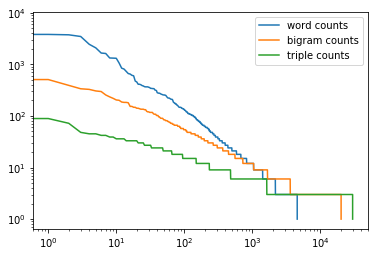

In [10]:
bigramcounts = [count for _,count in counter_pairs.most_common()]
triplecounts = [count for _,count in counter_triples.most_common()]
plt.loglog(wordcounts, label='word counts');
plt.loglog(bigramcounts, label='bigram counts');
plt.loglog(triplecounts, label='triple counts');
plt.legend();

The graph is quite exciting for a number of reasons. Firstly, beyond words, also sequences of words appear to be following
Zipf’s law, albeit with a lower exponent, depending on sequence length. Secondly, the number of distinct n-grams is not
that large. This gives us hope that there is quite a lot of structure in language. Third, many n-grams occur very rarely,
which makes Laplace smoothing rather unsuitable for language modeling. Instead, we will use deep learning based models.

## Summary

* Language models are an important technology for natural language processing.
* n-grams provide a convenient model for dealing with long sequences by truncating the dependence.
* Long sequences suffer from the problem that they occur very rarely or never. This requires smoothing, e.g. via
Bayesian Nonparametrics or alternatively via deep learning.
* Zipf’s law governs the word distribution for both unigrams and n-grams.
* There’s a lot of structure but not enough frequency to deal with infrequent word combinations efficiently via smoothing.

## Exercises

1. Suppose there are 100,000 words in the training data set. How many word frequencies and multi-word adjacent
frequencies does a four-gram need to store?
2. Review the smoothed probability estimates. Why are they not accurate? Hint - we are dealing with a contiguous
sequence rather than singletons.
3. How would you model a dialogue?
4. Estimate the exponent of Zipf’s law for unigrams, bigrams and trigrams.